# dat6_melb Final Project 

# <font color='blue'>1. Identify the problem</font>

<i> “Understand the relationship between Free to Air and Pay TV audiences for AFL matches.” </i>



# <font color='blue'>2. Acquire the data</font>

I was able to source detailed TV ratings data through OzTAM who monitor this sort of thing. The data has audiences for every match going back two years broken up by city and demographic (Male, Female, 0-17 years, 17-34 years, 34+)

# <font color='blue'>3. Parse the data</font>

I cheated slightly here and did some of the leg work in Excel purely because it's what I know and would have
taken me a really long time to get the same results using Python. 

The main thing I had to do here was convert a match name column (e.g. 'RND 1: SYDNEY V MELB') into two columns for Team 1 and Team 2. One issue I faced here were the inconsistent naming conventions for teams (e.g. NORTH MELBOURNE, NTH MELB, NTH
MELBOURNE).


# <font color='blue'>4. Mine the data</font>

In [1]:
# load in libraries

import pandas as pd
import numpy as np
import seaborn as sb

In [2]:
# load the csv
audience = pd.read_csv('AFL_audience.csv')

In [3]:
# check out the dataframe
audience.head(5)

,MatchID,Date,TEAM 1,TEAM 2,TYPE,Market,Exclusive,FTA,PAY
0,1,24/03/2016,RICHMOND,CARLTON,STANDARD,5 City Metro,0,611000,225000
1,1,24/03/2016,RICHMOND,CARLTON,STANDARD,Adelaide,0,86000,30000
2,1,24/03/2016,RICHMOND,CARLTON,STANDARD,Brisbane,0,30000,22000
3,1,24/03/2016,RICHMOND,CARLTON,STANDARD,Melbourne,0,388000,127000
4,1,24/03/2016,RICHMOND,CARLTON,STANDARD,Perth,0,79000,26000


In [4]:
# drop columns that won't really do anything in the model
audience.drop(columns = ['Date'], inplace=True)

# remove grand finals as they will be outliers
audience = audience.loc[audience['TYPE'] != 'GRAND FINAL']

## Start with some simple bar charts

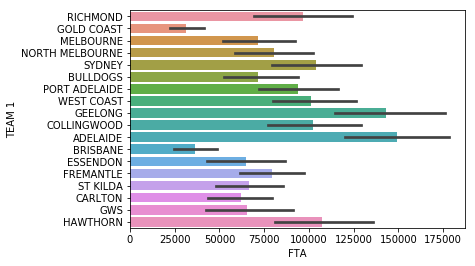

In [5]:
sb.barplot(data=audience, y="TEAM 1", x="FTA", estimator=np.mean);

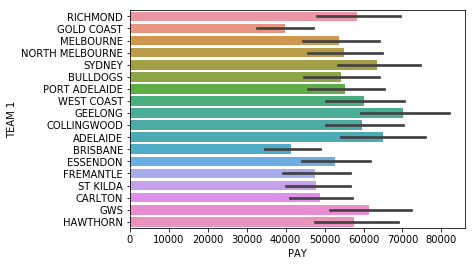

In [6]:
sb.barplot(data=audience, y="TEAM 1", x="PAY", estimator=np.mean);

In [7]:
# seems to be a lot less variation in Pay TV audiences and they are also typically much lower than Pay TV

## Check out some scatter plots

I ran various scatter plots before arriving at the data to include in the below - the big call here was whether I looked at the total across all 5 cities, or looked at them individually.

In [8]:
# filter the dataset further

# don't include 5 city metro market
audience_city = audience.loc[audience['Market'] != '5 City Metro']

# don't include payTV exclusives
audience_city = audience_city.loc[audience['Exclusive'] == 0]

# don't include matches with no audience
audience_city = audience_city.loc[audience['FTA'] > 0]
audience_city = audience_city.loc[audience['PAY'] > 0]

# don't incude Grand Finals
audience_city = audience_city.loc[audience['TYPE'] != 'GRAND FINAL']

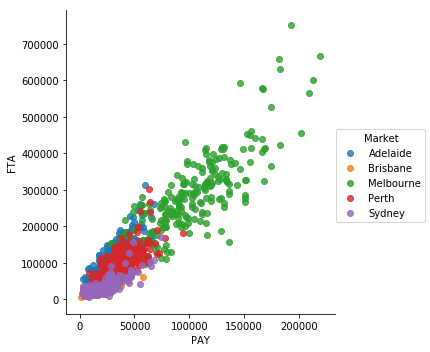

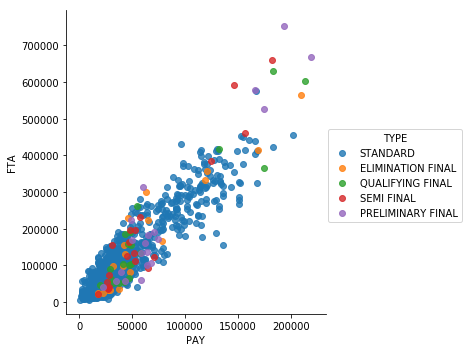

In [9]:
# let's try out a scatter
sb.lmplot( x='PAY', y='FTA', data=audience_city, fit_reg=False, hue='Market', legend=True)
sb.lmplot( x='PAY', y='FTA', data=audience_city, fit_reg=False, hue='TYPE', legend=True);

In [10]:
# looks pretty good! definitely some correlation there, now for a histogram

## Have a look at the distributions

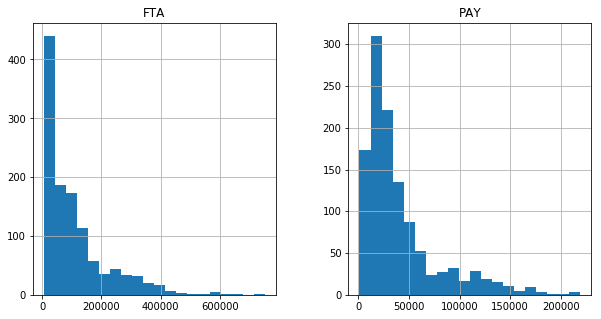

In [11]:
audience_city.hist(['PAY','FTA'], bins=20, figsize = (10,5));

## The audience numbers are both positively skewed, so we need to log transform the data

In [12]:
audience_city['PAY'] = np.log(audience_city['PAY'])
audience_city['FTA'] = np.log(audience_city['FTA'])

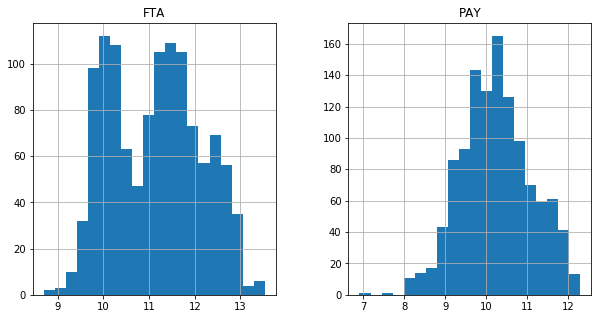

In [13]:
audience_city.hist(['PAY','FTA'], bins=20, figsize = (10,5));

In [14]:
# not great but better! got some bimodal distribution going on over there <-

## How do our scatter plots look with log transformed data?

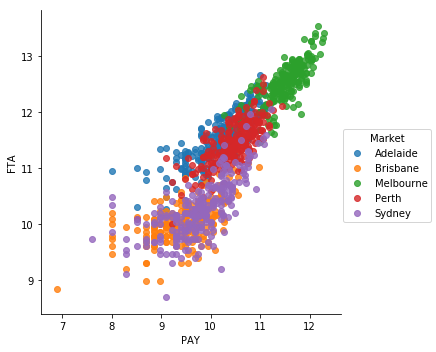

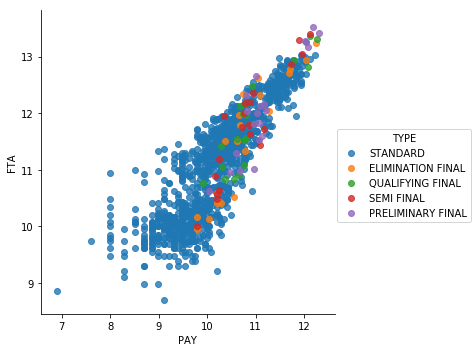

In [15]:
sb.lmplot( x='PAY', y='FTA', data=audience_city, fit_reg=False, hue='Market', legend=True)
sb.lmplot( x='PAY', y='FTA', data=audience_city, fit_reg=False, hue='TYPE', legend=True);

# <font color='blue'>5. Refine data</font>

I had to create dummy variables for the <b>teams</b> and <b>type of game</b>

In [16]:
# create dummary variables for teams
# this will require creating a dummy table for team 1 and team 2 and then adding one on top of the other
dummies_team_1 = pd.get_dummies(audience_city['TEAM 1'], prefix='team')

In [17]:
dummies_team_2 = pd.get_dummies(audience_city['TEAM 2'], prefix='team')

In [18]:
dummies_type = pd.get_dummies(audience_city['TYPE'], prefix='type')

In [36]:
# check the column headings
dummies_team_1.head(1)

,team_ADELAIDE,team_BRISBANE,team_BULLDOGS,team_CARLTON,team_COLLINGWOOD,team_ESSENDON,team_FREMANTLE,team_GEELONG,team_GOLD COAST,team_GWS,team_HAWTHORN,team_MELBOURNE,team_NORTH MELBOURNE,team_PORT ADELAIDE,team_RICHMOND,team_ST KILDA,team_SYDNEY,team_WEST COAST
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [20]:
# check the column headings
dummies_team_2.head(1)

,team_ADELAIDE,team_BRISBANE,team_BULLDOGS,team_CARLTON,team_COLLINGWOOD,team_ESSENDON,team_FREMANTLE,team_GEELONG,team_GOLD COAST,team_GWS,team_HAWTHORN,team_MELBOURNE,team_NORTH MELBOURNE,team_PORT ADELAIDE,team_RICHMOND,team_ST KILDA,team_SYDNEY,team_WEST COAST
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
# check the column headings
dummies_type.head(1)

,type_ELIMINATION FINAL,type_PRELIMINARY FINAL,type_QUALIFYING FINAL,type_SEMI FINAL,type_STANDARD
1,0,0,0,0,1


## After creating a dummy table for each team (home and away) I had to kind of add one table on top of the other so that both teams were represented

In [22]:
# add the two team dummies tables together so that both teams are represented
dummies_team = dummies_team_1 + dummies_team_2

## Then I joined the dummy tables back with the main dataset and dropped a bunch of columns

In [23]:
# join the dummy tables back to the main table
audience_city = audience_city.join([dummies_team, dummies_type])

In [24]:
audience_city = audience_city.drop(columns = ['MatchID','TEAM 1','TEAM 2','Market','Exclusive','TYPE'])

In [25]:
audience_city.head(5)

,FTA,PAY,team_ADELAIDE,team_BRISBANE,team_BULLDOGS,team_CARLTON,team_COLLINGWOOD,team_ESSENDON,team_FREMANTLE,team_GEELONG,...,team_PORT ADELAIDE,team_RICHMOND,team_ST KILDA,team_SYDNEY,team_WEST COAST,type_ELIMINATION FINAL,type_PRELIMINARY FINAL,type_QUALIFYING FINAL,type_SEMI FINAL,type_STANDARD
1,11.362103,10.308953,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,10.308953,9.998798,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,12.868761,11.751942,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,11.277203,10.165852,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
5,10.165852,9.903488,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


# <font color='blue'>6. Build the model</font>

I chose a random forest for this initially because they are apparently pretty good.

## Split into training and test sets

In [26]:
# for decision trees we have to convert our dataframes into numpy arrays (apparently that's how it works)
# labels are the values we want to predict
labels = np.array(audience_city['PAY'])

# drop the target from the dataframe
audience_city_features = audience_city.drop(columns = 'PAY')

# saving feature names for later use
feature_list = list(audience_city_features.columns)

features = np.array(audience_city_features)

In [27]:
# using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.33, random_state = 42)


In [28]:
# checking that all the lengths are correct
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (785, 24)
Training Labels Shape: (785,)
Testing Features Shape: (387, 24)
Testing Labels Shape: (387,)


## Import and train the Random Forest model

In [29]:
# import random forest
from sklearn.ensemble import RandomForestRegressor

# instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# train the model on training data
rf.fit(train_features, train_labels);

# <font color='blue'>7. Present the results</font>

## Test the trained model against the test data and provide some idea of how close it was

In [30]:
# use the forest's predict method on the test data
predictions = rf.predict(test_features)

# calculate the absolute errors
errors = abs(predictions - test_labels)

# print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'audience')

Mean Absolute Error: 0.31 audience


## I created a dataframe that had the actual and predicted values from the test set to visualise how the model worked

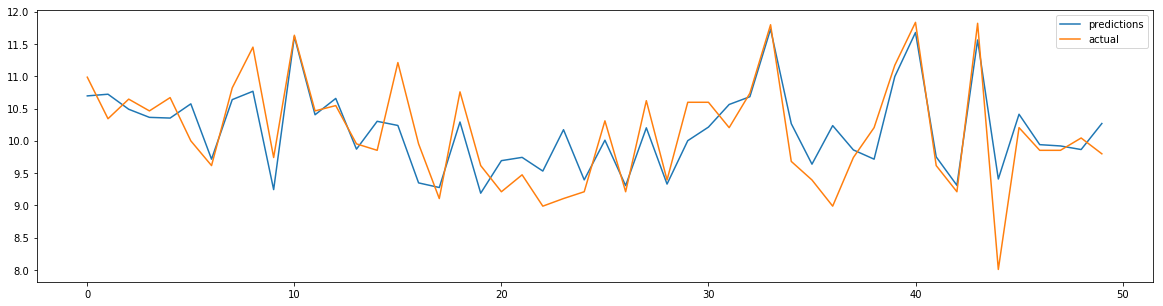

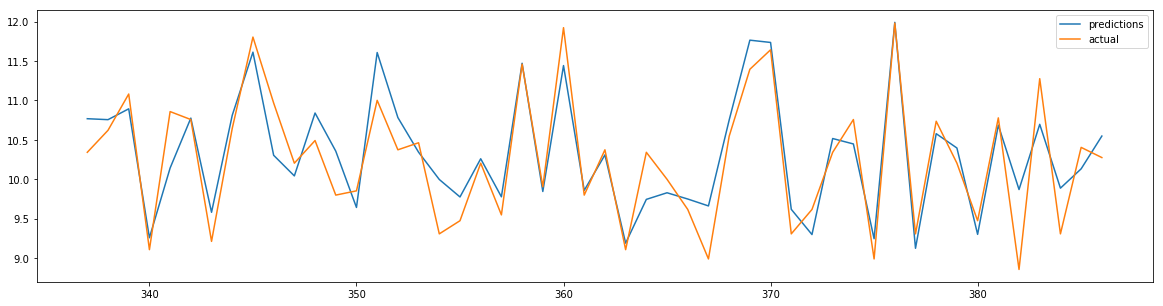

In [31]:
# create a dataframe that has a column for predictions and one for actuals to see what the outcome looks like
results = pd.DataFrame(data=predictions)
results.columns = ['predictions']
results['actual'] = test_labels
results.head(50).plot(figsize = (20,5))
results.tail(50).plot(figsize = (20,5));

## Interested to see how this looks if we convert back from log using np.exp

In [32]:
exp_results = pd.DataFrame(data=results)
exp_results['predictions'] = np.exp(results['predictions'])
exp_results['actual'] = np.exp(results['actual'])

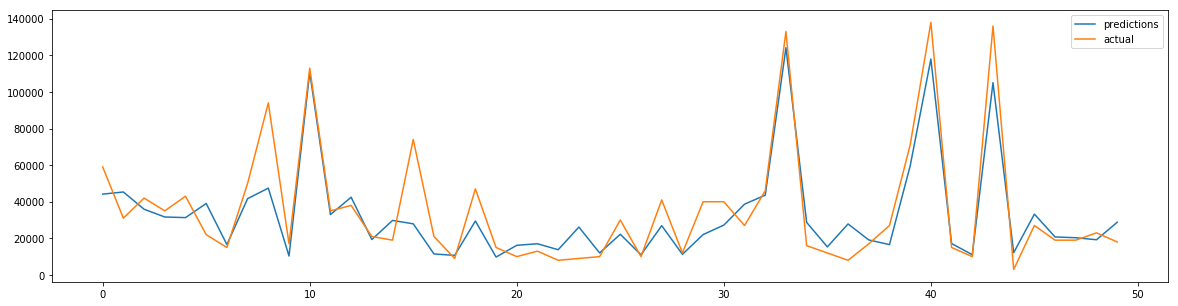

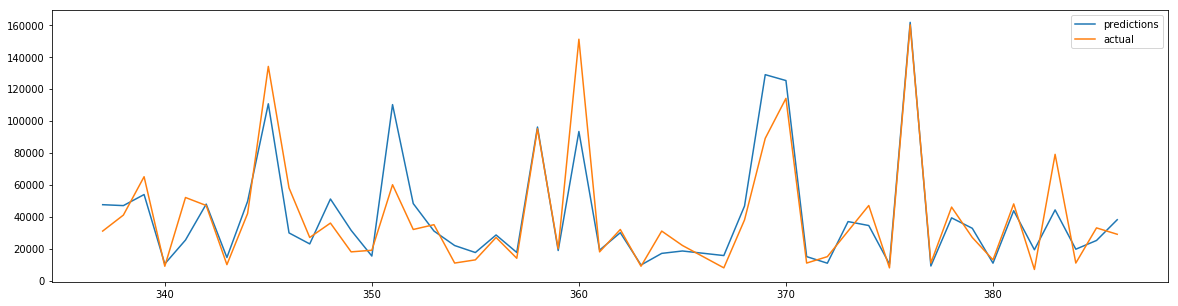

In [33]:
exp_results.head(50).plot(figsize = (20,5))
exp_results.tail(50).plot(figsize = (20,5));

## I found this cool way to view the importance of different variables

In [34]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: FTA                  Importance: 0.84
Variable: team_SYDNEY          Importance: 0.02
Variable: team_ADELAIDE        Importance: 0.01
Variable: team_BRISBANE        Importance: 0.01
Variable: team_BULLDOGS        Importance: 0.01
Variable: team_CARLTON         Importance: 0.01
Variable: team_COLLINGWOOD     Importance: 0.01
Variable: team_ESSENDON        Importance: 0.01
Variable: team_FREMANTLE       Importance: 0.01
Variable: team_GEELONG         Importance: 0.01
Variable: team_GOLD COAST      Importance: 0.01
Variable: team_GWS             Importance: 0.01
Variable: team_MELBOURNE       Importance: 0.01
Variable: team_NORTH MELBOURNE Importance: 0.01
Variable: team_PORT ADELAIDE   Importance: 0.01
Variable: team_RICHMOND        Importance: 0.01
Variable: team_ST KILDA        Importance: 0.01
Variable: team_WEST COAST      Importance: 0.01
Variable: type_STANDARD        Importance: 0.01
Variable: team_HAWTHORN        Importance: 0.0
Variable: type_ELIMINATION FINAL Importan

# <font color='blue'>Next steps</font>
I think there's still a lot I can do with this analysis:
1. I need to better understand how to now use this to predict actual values - I understand that I could load in a new 'test_set' of whatever values we wanted but need to actually do this
2. I think I should run the model for different cities and see how accurate it is on a per city basis

3. I wouldn't mind running a linear regression just to see how well that works as a comparison

4. I could probably refine the model quite a bit